In [1]:
import tensorflow.examples.tutorials.mnist as mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

In [2]:
%matplotlib inline

#### Dataset info

In [3]:
# source: http://yann.lecun.com/exdb/mnist/
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10

#### Loading files
Data is already preprocessed, shuffled and normalized.

In [4]:
mnist_dataset = mnist.input_data.read_data_sets('tensorflow/examples/tutorials/mnist', one_hot=True)

Extracting tensorflow/examples/tutorials/mnist/train-images-idx3-ubyte.gz
Extracting tensorflow/examples/tutorials/mnist/train-labels-idx1-ubyte.gz
Extracting tensorflow/examples/tutorials/mnist/t10k-images-idx3-ubyte.gz
Extracting tensorflow/examples/tutorials/mnist/t10k-labels-idx1-ubyte.gz


#### Divide data

In [5]:
trainX = mnist_dataset.train.images
valX = mnist_dataset.validation.images
testX = mnist_dataset.test.images

trainY = mnist_dataset.train.labels.astype(np.float32)
valY = mnist_dataset.validation.labels.astype(np.float32)
testY = mnist_dataset.test.labels.astype(np.float32)

In [6]:
TRAIN_IMAGES_NUM = trainX.shape[0]
TEST_IMAGES_NUM = testX.shape[0]

#### Present data

In [7]:
def show_digit(trainX, trainY, index):
    image = trainX[index].reshape([IMAGE_WIDTH, IMAGE_HEIGHT])
    label = trainY[index]
    plt.title("Training data, index: {},  Label: {}".format(index, label))
    plt.imshow(image, cmap="gray_r")
    plt.show()

trainX shape: (55000, 784)
trainY shape: (55000, 10)
valX shape: (5000, 784)
valY shape: (5000, 10)
testX shape: (10000, 784)
testY shape: (10000, 10)


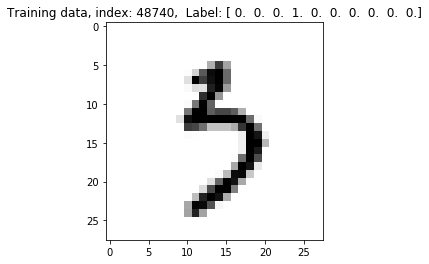

In [8]:
print("trainX shape: " + str(trainX.shape))
print("trainY shape: " + str(trainY.shape))
print("valX shape: " + str(valX.shape))
print("valY shape: " + str(valY.shape))
print("testX shape: " + str(testX.shape))
print("testY shape: " + str(testY.shape))
show_digit(trainX, trainY, np.random.randint(1, TRAIN_IMAGES_NUM + 1))

#### Neural Network preparation

In [9]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width * image_height * channels], name='inputs')

In [10]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [11]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [12]:
def conv_net_is_training_placeholder():
    return tf.placeholder(tf.bool)

In [13]:
def conv_net(inputs, keep_prob, is_training):   
    
    # Reshape into image
    input_layer = tf.reshape(inputs, [-1, IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS])
    
    # Conv Layer - 1, Input 28x28x1 -> BatchNorm -> ReLU -> MaxPooling -> Output 14x14x16
    conv1_layer = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=5, strides=1, 
                                   padding="SAME", use_bias=False, activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    conv1_layer_norm = tf.layers.batch_normalization(conv1_layer, training=is_training)
    conv1_layer_activated = tf.nn.relu(conv1_layer_norm)
    conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer_activated, pool_size=2, strides=2)
    
    # Conv Layer - 2, Input 16x16x16 -> BatchNorm -> ReLU -> MaxPooling -> Output 7x7x32
    conv2_layer = tf.layers.conv2d(inputs=conv1_layer_mpool, filters=32, kernel_size=3, strides=1, 
                                   padding="SAME", use_bias=False, activation=None, 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    conv2_layer_norm = tf.layers.batch_normalization(conv2_layer, training=is_training)
    conv2_layer_activated = tf.nn.relu(conv2_layer_norm)
    conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer_activated, pool_size=2, strides=2)

    # Conv Layer - 3, Input 7x7x32 -> BatchNorm -> ReLU -> MaxPooling -> Output 4x4x64
    conv3_layer = tf.layers.conv2d(inputs=conv2_layer_mpool, filters=64, kernel_size=3, strides=1,
                                   padding="SAME", use_bias=False, activation=None,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    conv3_layer_norm = tf.layers.batch_normalization(conv3_layer, training=is_training)
    conv3_layer_activated = tf.nn.relu(conv3_layer_norm)
    conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer_activated, pool_size=2, strides=2)
    
    # Conv Layer Flattened
    conv_output_shape = conv3_layer_mpool.get_shape().as_list()
    flatten=tf.reshape(conv3_layer_mpool,
                       [-1, conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]])
    
    # Dense Layer - 1
    dense1_layer = tf.layers.dense(inputs=flatten, units=128, use_bias=False, activation=None)
    dense1_layer_norm = tf.layers.batch_normalization(dense1_layer, training=is_training)
    dense1_layer_activated = tf.nn.relu(dense1_layer_norm)
    dense1_layer_dropout = tf.layers.dropout(inputs=dense1_layer_activated, rate=keep_prob)
    
    # Output Layer 
    output = tf.layers.dense(inputs=dense1_layer_dropout, units=NUM_LABELS, activation=None)
    
    return output

#### Batches utils

In [14]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Building model

In [15]:
tf.reset_default_graph()

In [16]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)
targets = conv_net_label_input(NUM_LABELS)
keep_prob = conv_net_keep_prob_input()
is_training = conv_net_is_training_placeholder()

model = conv_net(inputs, keep_prob, is_training)

In [17]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))

optimizer_step = 1e-4
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer(optimizer_step).minimize(cost)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Hyperparameters

In [18]:
epochs = 15
batch_size = 256
keep_probability = 0.5

#### Training cycle

In [19]:
session = tf.Session()

In [20]:
session.run(tf.global_variables_initializer())

batch_count = 0
info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(trainX, trainY, batch_size)

    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, 
                                          targets: label_batch, 
                                          keep_prob: keep_probability, 
                                          is_training: True})
        if (batch_count % 50) == 0:
            train_cost = session.run(cost, feed_dict={
                    inputs: data_batch, targets: label_batch, keep_prob: 1., is_training: False})

            train_acc = session.run(accuracy, feed_dict={
                inputs: data_batch, targets: label_batch, keep_prob: 1., is_training: False})

            info["train_cost"].append(train_cost)
            info["train_acc"].append(train_acc)

            valid_cost = session.run(cost, feed_dict={
                inputs: valX, targets: valY, keep_prob: 1., is_training: False})

            valid_acc = session.run(accuracy, feed_dict={
                inputs: valX, targets: valY, keep_prob: 1., is_training: False})

            info["valid_cost"].append(valid_cost)
            info["valid_acc"].append(valid_acc)

            print('Epoch {}, Batch {}:  '.format(epoch + 1, batch_count), end='')
            print("Train cost = {:.4f},".format(train_cost), 
                  "Train acc = {:.4f}".format(train_acc),
                  "Val cost = {:.4f},".format(valid_cost), 
                  "Val acc = {:.4f}".format(valid_acc))    

Epoch 1, Batch 50:  Train cost = 2.3918, Train acc = 0.1211 Val cost = 2.3693, Val acc = 0.1286
Epoch 1, Batch 100:  Train cost = 2.7842, Train acc = 0.1016 Val cost = 2.7233, Val acc = 0.1126
Epoch 1, Batch 150:  Train cost = 3.0882, Train acc = 0.1133 Val cost = 3.0632, Val acc = 0.1126
Epoch 1, Batch 200:  Train cost = 3.3367, Train acc = 0.1172 Val cost = 3.1859, Val acc = 0.1136
Epoch 2, Batch 250:  Train cost = 3.0281, Train acc = 0.1602 Val cost = 3.0320, Val acc = 0.1414
Epoch 2, Batch 300:  Train cost = 2.7021, Train acc = 0.1953 Val cost = 2.6623, Val acc = 0.1970
Epoch 2, Batch 350:  Train cost = 2.0839, Train acc = 0.3438 Val cost = 2.0668, Val acc = 0.3276
Epoch 2, Batch 400:  Train cost = 1.4528, Train acc = 0.5508 Val cost = 1.4189, Val acc = 0.5344
Epoch 3, Batch 450:  Train cost = 0.9105, Train acc = 0.6953 Val cost = 0.9089, Val acc = 0.7018
Epoch 3, Batch 500:  Train cost = 0.4560, Train acc = 0.8633 Val cost = 0.4993, Val acc = 0.8610
Epoch 3, Batch 550:  Train cost

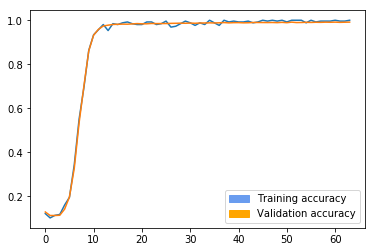

In [21]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

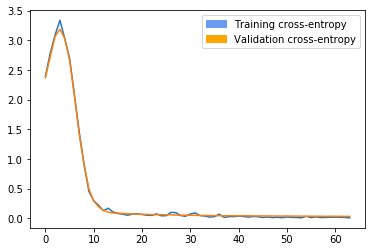

In [22]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [23]:
test_acc = session.run(accuracy, feed_dict={
    inputs: valX, targets: valY, keep_prob: 1., is_training: False})
print("Test data accuracy: " + str(test_acc))

Test data accuracy: 0.9918


In [24]:
session.close()